In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from IS2ML_utils import *

In [3]:
# get the stats for all lakes
# fn_lakestats = '../GLD3_GrIS_lakestats.csv'
# fn_lakestats = '../FLUID-SuRRF_GrIS2019-23_lakestats.csv'
fn_lakestats = '../FLUID-SuRRF_AIS2019-23_lakestats.csv'
# fn_lakestats = '../FLUID-SuRRF_AIS2019-23_lakestats_all.csv'
df = pd.read_csv(fn_lakestats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='EPSG:3413')
gdfg = gdf[gdf.label=='good_lake']

In [4]:
# specify where the data lives (this is from the FLUID-SuRRF output file structure)
# need to adjust the base_dir
kwargs = {
    'base_dir': '/Users/parndt/jupyterprojects/GLD3_complete/AIS/',  # base directory where the fluid surrf data lives
    'data_dir': 'detection_out_data/',                                # the directory with the data files (structure from output)
    'ground_track_buffer': 7.5,          # radius in meters, for a 11-m diameter footprint and some allowance for geolocation uncertainty
    'max_cloudiness': 20,                # 20 seems to be good, sometimes over lakes the cloudScore thinks there are clouds
    'days_buffer': 7,                    # limit to +/- one week from ICESat-2 acquisition, can later filter for NDWI overlap / correlation with band reflectances
    'min_sun_elevation': 20,             # 20 is commonly used, beelow that data often has issues
    'limit_n_imgs': 20,                  # limit the total number of images queried, ground track points with missing data after this are discarded
    'ndwi_thresh': 0.125,                 # this threshold is used to calculate NDWI overlap between ICESat-2 and Sentinel-2 water extent
    're_calculate_if_existing': False, # re-do calculations even if file already exists
    'FLUID_SuRRF_info': gdfg
}

Only uncomment and run the code below when doing a full new run! 

In [4]:
# ###########################################################################################################
# ### for a clean, new run: clear the output data (except for metadata files from Sentinel-2)
# ###########################################################################################################
# folders_to_reset = ['training_data_CSVs', 'imagery_gt', 'atl03_segments']
# for folder in folders_to_reset:
#     ! rm -rf $folder
#     os.makedirs(folder)
#     open('%s/.gitkeep' % folder,'a').close()


_________________________________________________ lake  2556 /  3559 _________________________________________________

lake_099982_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190107072235_01500212_006_02_gt3r_0023
--> already processed, skipping...

_________________________________________________ lake  2557 /  3559 _________________________________________________

lake_099982_AIS_2018-19_simplified_ANT_1000_East_Jpp-K_ATL03_20190104162517_01100211_006_02_gt1r_0001
--> already processed, skipping...

_________________________________________________ lake  2558 /  3559 _________________________________________________

lake_099982_AIS_2019-20_simplified_ANT_1000_East_B-C_ATL03_20200101141003_00890612_006_01_gt1l_0000
--> getting Sentinel-2 Level-2A collection
--> there are 8 images for the given parameters  [days_buffer=7, min_sun_elevation=20, max_cloudiness=20, limit_n_imgs=20]
    image  1: --> fully in footprint --> get EE data --> get metadata from S3 attempting to downloa

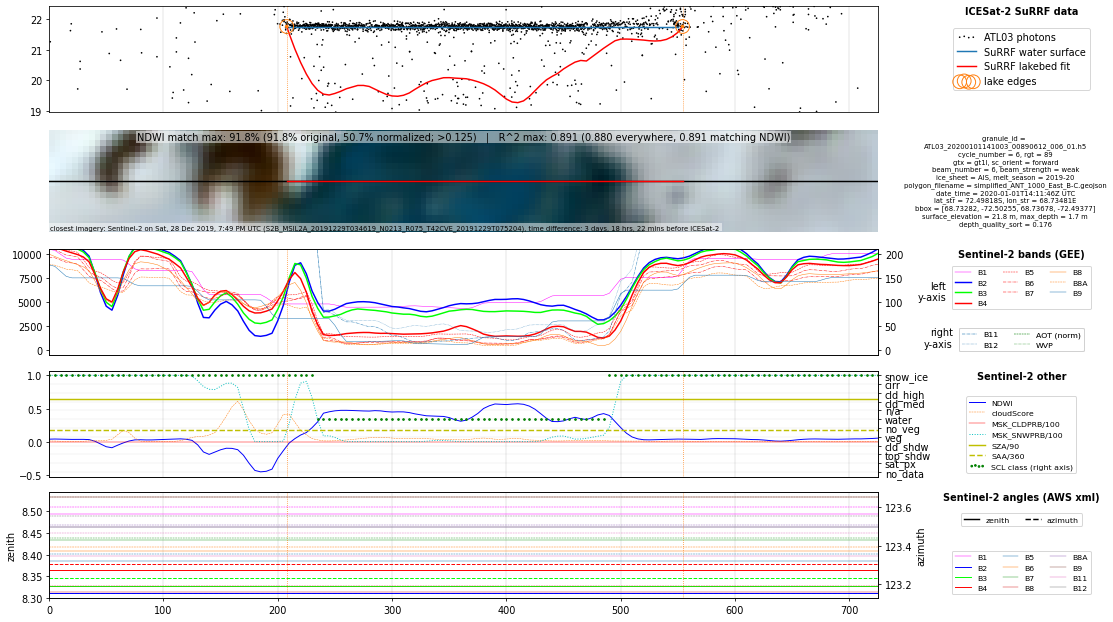

In [ ]:
clear_outputs = True
iterate = gdfg.lake_id
for ilk, lake_id in enumerate(iterate):
    if (ilk < (len(iterate)-1)) and clear_outputs and (ilk % 5 == 0):
        clear_output(wait=True)
    print('\n_________________________________________________ lake %5i / %5i _________________________________________________\n' % (ilk+1, len(gdfg)))
    try:
        fig_path, lk, gdf_final, lk_info = get_data_and_plot(lake_id=lake_id, **kwargs)
    except:
        warnings.warn('Getting data failed for lake %i! (%s)' % (ilk+1, lake_id))
        traceback.print_exc()

# Clean up data and compile into parquet format

In [5]:
# compile all data together
base_dir = 'training_data_CSVs'

if base_dir[-1] != '/':
    base_dir += '/'
    
searchdir = base_dir
searchfor = '_lakeinfo.csv'
filelist_info = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
filelist_info.sort()
listlength_info = len(filelist_info)
print('number *_lakeinfo.csv:', listlength_info)

searchfor = '.csv'
exclude = '_lakeinfo.csv'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & (exclude not in f)]
filelist.sort()
listlength = len(filelist)
print('number *.csv:', listlength)

number *_lakeinfo.csv: 2213
number *.csv: 2213


In [6]:
dfs = []
print('compiling info')
for ifn, fninfo in enumerate(filelist_info):
    print('%5i / %5i' % (ifn+1, listlength_info), end='\r')
    dfs.append(pd.read_csv(fninfo))
dfinfo = pd.concat(dfs)

dfs = []
print('\n\ncompiling data')
for ifn, fn in enumerate(filelist):
    print('%5i / %5i' % (ifn+1, listlength_info), end='\r')
    dfs.append(pd.read_csv(fn))
df_data = pd.concat(dfs).reset_index(drop=True)

print('\n\n --> done.')

compiling info
 2213 /  2213

compiling data
 2213 /  2213

 --> done.


In [9]:
list(df_saveinfo)

['label',
 'ice_sheet',
 'melt_season',
 'date_time',
 'lon',
 'lat',
 'surface_elevation',
 'depth_quality_sort',
 'max_depth',
 'cycle_number',
 'rgt',
 'gtx',
 'beam_strength',
 'beam_number',
 'sc_orient',
 'granule_id',
 'polygon_name',
 'lat_max',
 'lat_min',
 'lon_max',
 'lon_min',
 'has_depth_data',
 'conf_mean',
 'conf_median',
 'conf_q90',
 'length_water',
 'total_length',
 'depth_mean',
 'depth_median',
 'ratio_water',
 'geometry',
 'basin',
 'region',
 'sub_basin',
 'grounded',
 'datetime_S2',
 'tdiff_str',
 'tdiff_sec_mean',
 'tdiff_sec_min',
 'tdiff_sec_max',
 'n_scenes',
 'S2_id_first',
 'fluidsurrf_file_id',
 'ndwi_thresh',
 'ndwi_match_perc',
 'ndwi_match_perc_norm',
 'ndwi_match_perc_depth',
 'ndwi_match_perc_max',
 'Rsquared_log_B2B3',
 'Rsquared_log_B2B3_match',
 'Rsquared_log_B2',
 'Rsquared_log_B2_match',
 'Rsquared_log_B3',
 'Rsquared_log_B3_match',
 'Rsquared_log_B4',
 'Rsquared_log_B4_match',
 'Rsquared_max_full',
 'Rsquared_max_match',
 'Rsquared_max']

In [10]:
# Ignore specific warnings
import scipy
warnings.filterwarnings("ignore", category=scipy.stats.ConstantInputWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in log")
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

df_save = df_data.copy()
df_saveinfo = dfinfo.copy()

# give matching id columns the same name
df_saveinfo = df_saveinfo.rename(columns={'lake_id': 'IS2_id'})

# drop unnecessary elevation info from IS2
df_save = df_save.drop(columns=['h_fit_surf', 'h_fit_bed'])

# remove nan data 
df_save = df_save[~df_save.isna().any(axis=1)].reset_index(drop=True)

# cast surface classification to uint8
df_save.SCL = df_save.SCL.astype(np.uint8)

# filter out confidence values lower than 0.05 so nobody grossly abuses data that can't be trusted
conf_thresh = 0.05
df_save = df_save[df_save.conf > conf_thresh]

def norma(x):
    xn = x - np.nanmin(x)
    return xn / np.nanmax(xn)

def check_finite(arr1, arr2):
    return ~(np.isinf(arr1) | np.isnan(arr1) | np.isinf(arr2) | np.isnan(arr2))

def get_matching_stats(col, ndwi_thresh=0.125, min_valid_values=10, conf_thresh=conf_thresh):

    min_fin = min_valid_values
    
    ndwi_match = (col.depth > 0) == (col.ndwi > ndwi_thresh)
    fin = check_finite(col.depth, col.ndwi)
    mat = ndwi_match & fin
    ndwi_match_perc = 0.0 if (np.sum(mat) < min_fin) else ndwi_match.mean() * 100

    ndwi_match_depth = (col.depth > 0) & (col.ndwi > ndwi_thresh)
    is_depth = col.depth > 0
    fin = check_finite(col.depth, col.ndwi)
    mat = ndwi_match_depth & fin
    ndwi_match_perc_depth = 0.0 if (np.sum(mat) < min_fin) else ndwi_match_depth.sum() / is_depth.sum() * 100
    
    ndwi_match_norm = (col.depth > 0) == (norma(col.ndwi) > ndwi_thresh)
    fin = check_finite(col.depth, norma(col.ndwi))
    mat = ndwi_match & fin
    ndwi_match_perc_norm = 0.0 if (np.sum(mat) < min_fin) else ndwi_match_norm.mean() * 100

    ndwi_match_perc_max = np.nanmax((ndwi_match_perc, ndwi_match_perc_norm, 0.0))

    ndwi_match = ndwi_match_depth & (col.conf >= conf_thresh) # use only values where ICESat-2 sees a water depth
    bg_avg = norma(np.mean(np.vstack((norma(np.log(col.B2)), norma(np.log(col.B3)))), axis=0))
    fin = check_finite(col.depth, bg_avg)
    mat = ndwi_match & fin
    Rsquared_log_B2B3 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], bg_avg[fin]).statistic
    Rsquared_log_B2B3_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], bg_avg[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B2))
    mat = ndwi_match & fin
    Rsquared_log_B2 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B2)[fin]).statistic
    Rsquared_log_B2_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B2)[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B3))
    mat = ndwi_match & fin
    Rsquared_log_B3 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B3)[fin]).statistic
    Rsquared_log_B3_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B3)[mat]).statistic
    fin = check_finite(col.depth, np.log(col.B4))
    mat = ndwi_match & fin
    Rsquared_log_B4 = -1.0 if (np.sum(fin) < min_fin) else pearsonr(-col.depth[fin], np.log(col.B4)[fin]).statistic
    Rsquared_log_B4_match = -1.0 if (np.sum(mat) < min_fin) else pearsonr(-col.depth[mat], np.log(col.B4)[mat]).statistic
    Rsquared_max_full = np.nanmax((Rsquared_log_B2, Rsquared_log_B3, Rsquared_log_B4, Rsquared_log_B2B3, -1.0))
    Rsquared_max_match = np.nanmax((Rsquared_log_B2_match, Rsquared_log_B3_match, Rsquared_log_B4_match, Rsquared_log_B2B3_match, -1.0))
    Rsquared_max = np.nanmax((Rsquared_max_full, Rsquared_max_match, -1.0))

    return pd.Series({
        'ndwi_thresh': ndwi_thresh,
        'ndwi_match_perc': ndwi_match_perc,
        'ndwi_match_perc_norm': ndwi_match_perc_norm,
        'ndwi_match_perc_depth': ndwi_match_perc_depth,
        'ndwi_match_perc_max': ndwi_match_perc_max,
        'Rsquared_log_B2B3': Rsquared_log_B2B3,
        'Rsquared_log_B2B3_match': Rsquared_log_B2B3_match,
        'Rsquared_log_B2': Rsquared_log_B2,
        'Rsquared_log_B2_match': Rsquared_log_B2_match,
        'Rsquared_log_B3': Rsquared_log_B3,
        'Rsquared_log_B3_match': Rsquared_log_B3_match,
        'Rsquared_log_B4': Rsquared_log_B4,
        'Rsquared_log_B4_match': Rsquared_log_B4_match,
        'Rsquared_max_full': Rsquared_max_full,
        'Rsquared_max_match': Rsquared_max_match,
        'Rsquared_max': Rsquared_max,
    })

is2groups = df_save.groupby('IS2_id')
df_info_new = is2groups.apply(get_matching_stats)
df_saveinfo = df_saveinfo.drop(columns=[
    'ndwi_match_perc',
    'ndwi_match_perc_norm',
    'ndwi_match_perc_max',
    'ndwi_thresh',
    'Rsquared_log_B2B3',
    'Rsquared_log_B2B3_match',
    'Rsquared_log_B2',
    'Rsquared_log_B2_match',
    'Rsquared_log_B3',
    'Rsquared_log_B3_match',
    'Rsquared_log_B4',
    'Rsquared_log_B4_match',
    'Rsquared_max_full',
    'Rsquared_max_match',
    'Rsquared_max']).set_index('IS2_id').join(df_info_new)

is_zero_depth = is2groups['depth'].max() == 0.0
not_zero_depth_indices = is_zero_depth[~is_zero_depth].index
not_zero_depth = df_save.apply(lambda x: x.IS2_id in not_zero_depth_indices, axis=1)
df_save = df_save[not_zero_depth].reset_index(drop=True)

# remove any info for lake segments that have been fully removed (just in case)
is2ids = np.unique(df_save.IS2_id)
is_in_data = df_saveinfo.apply(lambda x: x.name in is2ids, axis=1)
df_saveinfo = df_saveinfo[is_in_data]

# sort by estimated ICESat-2 quality
df_save['depth_quality_sort'] = df_save.apply(lambda x: df_saveinfo.loc[x.IS2_id,'depth_quality_sort'], axis=1)
df_save = df_save.sort_values(by=['depth_quality_sort', 'IS2_id', 'xatc'], ascending=[False, True, True])
df_saveinfo = df_saveinfo.sort_values(by='depth_quality_sort', ascending=False)

df_saveinfo = df_saveinfo[[
    'ice_sheet',
    'melt_season',
    'date_time',
    'lon',
    'lat',
    'surface_elevation',
    'depth_quality_sort',
    'max_depth',
    'cycle_number',
    'rgt',
    'gtx',
    'beam_strength',
    'beam_number',
    'sc_orient',
    'granule_id',
    'polygon_name',
    'lat_max',
    'lat_min',
    'lon_max',
    'lon_min',
    'conf_mean',
    'conf_median',
    'conf_q90',
    'length_water',
    'total_length',
    'depth_mean',
    'depth_median',
    'ratio_water',
    'ndwi_thresh',
    'ndwi_match_perc',
    'ndwi_match_perc_norm',
    'ndwi_match_perc_depth',
    'ndwi_match_perc_max',
    'Rsquared_log_B2B3',
    'Rsquared_log_B2B3_match',
    'Rsquared_log_B2',
    'Rsquared_log_B2_match',
    'Rsquared_log_B3',
    'Rsquared_log_B3_match',
    'Rsquared_log_B4',
    'Rsquared_log_B4_match',
    'Rsquared_max_full',
    'Rsquared_max_match',
    'Rsquared_max',
    'datetime_S2',
    'tdiff_str',
    'tdiff_sec_mean',
    'tdiff_sec_min',
    'tdiff_sec_max',
    'n_scenes',
    'basin',
    'region',
    'sub_basin',
    'grounded',
    'S2_id_first'
]]

df_save = df_save.drop(columns=['depth_quality_sort']).reset_index(drop=True)

## save to files

In [18]:
df_save['xatc'] = df_save.xatc.astype(np.uint16)

In [20]:
fn_out_info = 'training_data_ais/lake_segment_properties.csv'
fn_out_data = 'training_data_ais/lake_segments_depth_reflectance_S2.csv'

import pyarrow as pa
fn_out_data_pq = fn_out_data.replace('.csv', '.parquet')
SCHEMA = pa.schema([
    ('lat', pa.float32()),
    ('lon', pa.float32()),
    ('xatc', pa.uint16()),
    ('depth', pa.float32()),
    ('conf', pa.float32()),
    ('B1', pa.float32()),
    ('B2', pa.float32()),
    ('B3', pa.float32()),
    ('B4', pa.float32()),
    ('B5', pa.float32()),
    ('B6', pa.float32()),
    ('B7', pa.float32()),
    ('B8', pa.float32()),
    ('B8A', pa.float32()),
    ('B9', pa.float32()),
    ('B11', pa.float32()),
    ('B12', pa.float32()),
    ('AOT', pa.float32()),
    ('WVP', pa.float32()),
    ('SCL', pa.uint8()),
    ('MSK_CLDPRB', pa.float32()),
    ('MSK_SNWPRB', pa.float32()),
    ('cloudScore', pa.float32()),
    ('ndwi', pa.float32()),
    ('SZA', pa.float32()),
    ('SAA', pa.float32()),
    ('VZA_B1', pa.float32()),
    ('VZA_B2', pa.float32()),
    ('VZA_B3', pa.float32()),
    ('VZA_B4', pa.float32()),
    ('VZA_B5', pa.float32()),
    ('VZA_B6', pa.float32()),
    ('VZA_B7', pa.float32()),
    ('VZA_B8', pa.float32()),
    ('VZA_B8A', pa.float32()),
    ('VZA_B9', pa.float32()),
    ('VZA_B11', pa.float32()),
    ('VZA_B12', pa.float32()),
    ('VAA_B1', pa.float32()),
    ('VAA_B2', pa.float32()),
    ('VAA_B3', pa.float32()),
    ('VAA_B4', pa.float32()),
    ('VAA_B5', pa.float32()),
    ('VAA_B6', pa.float32()),
    ('VAA_B7', pa.float32()),
    ('VAA_B8', pa.float32()),
    ('VAA_B8A', pa.float32()),
    ('VAA_B9', pa.float32()),
    ('VAA_B11', pa.float32()),
    ('VAA_B12', pa.float32()),
    ('tdiff_sec', pa.uint32()),
    ('plot_id', pa.uint16()),
    ('S2_id', pa.string()),
    ('IS2_id', pa.string()),
])
df_save.to_parquet(fn_out_data_pq, schema=SCHEMA)
print('\n--> saved file as %s' % fn_out_data_pq)

fn_out_info_pq = fn_out_info.replace('.csv', '.parquet')
df_saveinfo.to_parquet(fn_out_info_pq)
print('\n--> saved file as %s' % fn_out_info_pq)

df_saveinfo.to_csv(fn_out_info)
print('\n--> saved file as %s' % fn_out_info)

df_save.to_csv(fn_out_data, index=False)
print('\n--> saved file as %s' % fn_out_data)


--> saved file as training_data_ais/lake_segments_depth_reflectance_S2.parquet

--> saved file as training_data_ais/lake_segment_properties.parquet

--> saved file as training_data_ais/lake_segment_properties.csv

--> saved file as training_data_ais/lake_segments_depth_reflectance_S2.csv
